In [13]:
import os, re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
import joblib

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 200)

In [17]:
path = "spam_ham_dataset.csv"  

df = pd.read_csv(path, encoding="utf-8", engine="python", on_bad_lines="skip")

if {"label","text"}.issubset(set(df.columns)):
    df = df[["label","text"]]
else:
    df = df.rename(columns={df.columns[0]:"label", df.columns[-1]:"text"})[["label","text"]]

df = df.dropna(subset=["label","text"]).copy()
df["label"] = df["label"].astype(str).str.strip().str.lower().replace({"1":"spam","0":"ham"})
df["text"] = df["text"].astype(str)

le = LabelEncoder()
y = le.fit_transform(df["label"])
X = df["text"]

df.head(10)

,label,text
0,ham,"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily vo..."
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see attached file : hplnol 09 . xls )\r\n- hplnol 09 . xls"
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !\r\ni know that this time of year is extremely hectic , and that it ' s ..."
3,spam,"Subject: photoshop , windows , office . cheap . main trending\r\nabasements darer prudently fortuitous undergone\r\nlighthearted charm orinoco taster\r\nrailroad affluent pornographic cuvier\r\nir..."
4,ham,"Subject: re : indian springs\r\nthis deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a check , i haven ' t received an answer as to whether there is a\r\np..."
5,ham,"Subject: ehronline web address change\r\nthis message is intended for ehronline users only .\r\ndue to a recent change to ehronline , the url ( aka "" web address "" ) for accessing ehronline needs ..."
6,ham,"Subject: spring savings certificate - take 30 % off\r\nsave 30 % when you use our customer appreciation spring savings\r\ncertificate at foot locker , lady foot locker , kids foot locker and at\r\..."
7,spam,"Subject: looking for medication ? we ` re the best source .\r\nit is difficult to make our material condition better by the best law , but it is easy enough to ruin it by bad laws .\r\nexcuse me ...."
8,ham,Subject: noms / actual flow for 2 / 26\r\nwe agree\r\n- - - - - - - - - - - - - - - - - - - - - - forwarded by melissa jones / texas utilities on\r\n02 / 27 / 2001\r\n10 : 33 am - - - - - - - - - ...
9,ham,"Subject: nominations for oct . 21 - 23 , 2000\r\n( see attached file : hplnl 021 . xls )\r\n- hplnl 021 . xls"


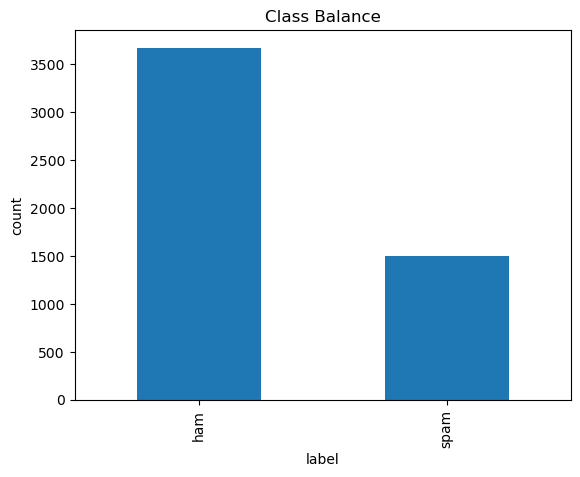

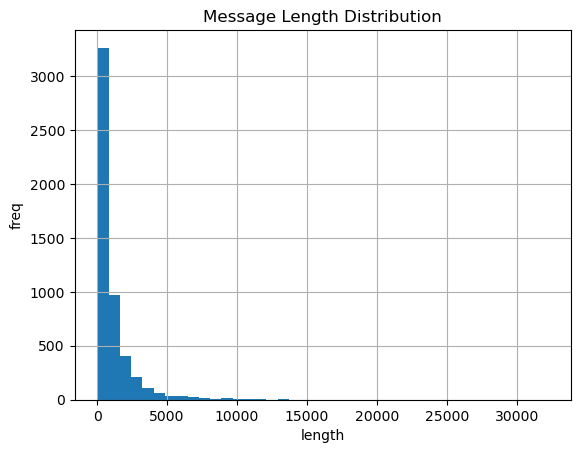

In [16]:
df["label"].value_counts().plot(kind="bar", title="Class Balance")
plt.xlabel("label"); plt.ylabel("count"); plt.show()

X.str.len().hist(bins=40)
plt.title("Message Length Distribution"); plt.xlabel("length"); plt.ylabel("freq"); plt.show()

In [18]:
def basic_clean(series):
    s = series.str.lower()
    s = s.str.replace(r"http\S+|www\S+"," ", regex=True)
    s = s.str.replace(r"\d+"," ", regex=True)
    s = s.str.replace(f"[{re.escape(string.punctuation)}]", " ", regex=True)
    s = s.str.replace(r"\s+"," ", regex=True).str.strip()
    return s

cleaner = FunctionTransformer(basic_clean)
word_tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
char_tfidf = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=2, max_df=0.95)
features = FeatureUnion([("word_tfidf", word_tfidf), ("char_tfidf", char_tfidf)])

In [19]:
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "LinearSVC": LinearSVC(),
    "SGDClassifier": SGDClassifier(loss="log_loss", max_iter=2000),
    "PassiveAggressive": PassiveAggressiveClassifier(max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42)
}
len(models), list(models.keys())


(6,
 ['MultinomialNB',
  'LogisticRegression',
  'LinearSVC',
  'SGDClassifier',
  'PassiveAggressive',
  'RandomForest'])

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
len(X_train), len(X_val)

(4136, 1035)

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"acc":"accuracy","prec":"precision","rec":"recall","f1":"f1"}

rows = []
for name, clf in models.items():
    pipe = Pipeline([("clean", cleaner), ("feat", features), ("clf", clf)])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    rows.append({
        "model": name,
        "acc_mean": scores["test_acc"].mean(),
        "prec_mean": scores["test_prec"].mean(),
        "rec_mean": scores["test_rec"].mean(),
        "f1_mean": scores["test_f1"].mean()
    })

cv_df = pd.DataFrame(rows).sort_values("f1_mean", ascending=False).reset_index(drop=True)
cv_df

,model,acc_mean,prec_mean,rec_mean,f1_mean
0,PassiveAggressive,0.988877,0.974662,0.987493,0.980970
1,LinearSVC,0.988151,0.969247,0.990826,0.979855
2,LogisticRegression,0.986943,0.971369,0.984160,0.977661
3,SGDClassifier,0.986701,0.968299,0.986663,0.977315
4,RandomForest,0.977515,0.950507,0.973330,0.961686
5,MultinomialNB,0.883705,0.995866,0.601315,0.749251


In [22]:
best_name = cv_df.iloc[0]["model"]
best_clf = models[best_name]

pipe = Pipeline([("clean", cleaner), ("feat", features), ("clf", best_clf)])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_val)

acc = accuracy_score(y_val, pred)
prec = precision_score(y_val, pred)
rec = recall_score(y_val, pred)
f1 = f1_score(y_val, pred)
cm = confusion_matrix(y_val, pred)

print("Best model:", best_name)
print("Accuracy:", round(acc,4))
print("Precision:", round(prec,4))
print("Recall:", round(rec,4))
print("F1:", round(f1,4))
print()
print(classification_report(y_val, pred, target_names=list(le.classes_)))

pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

Best model: PassiveAggressive
Accuracy: 0.9865
Precision: 0.9831
Recall: 0.97
F1: 0.9765

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       735
        spam       0.98      0.97      0.98       300

    accuracy                           0.99      1035
   macro avg       0.99      0.98      0.98      1035
weighted avg       0.99      0.99      0.99      1035



,ham,spam
ham,730,5
spam,9,291


In [26]:
param_distributions = {}

if best_name == "LogisticRegression":
    param_distributions = {"clf__C": np.logspace(-3, 2, 20), "clf__penalty": ["l2"], "clf__solver": ["lbfgs"]}
elif best_name == "LinearSVC":
    param_distributions = {"clf__C": np.logspace(-3, 2, 20)}
elif best_name == "MultinomialNB":
    param_distributions = {"clf__alpha": np.linspace(0.05, 2.0, 30)}
elif best_name == "SGDClassifier":
    param_distributions = {"clf__alpha": np.logspace(-6, -2, 20), "clf__loss": ["log_loss","hinge"]}
elif best_name == "PassiveAggressive":
    param_distributions = {"clf__C": np.logspace(-3, 1, 12), "clf__loss": ["hinge","squared_hinge"]}
elif best_name == "RandomForest":
    param_distributions = {"clf__n_estimators": [200,300,400,600], "clf__max_depth": [None,10,20,30]}

if len(param_distributions) > 0:
    base_pipe = Pipeline([("clean", cleaner), ("feat", features), ("clf", best_clf)])
    tuner = RandomizedSearchCV(
        base_pipe,
        param_distributions=param_distributions,
        n_iter=15,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring="f1",
        n_jobs=-1,
        random_state=42
    )
    tuner.fit(X_train, y_train)
    tuned_pipe = tuner.best_estimator_
else:
    tuned_pipe = pipe

tuned_pred = tuned_pipe.predict(X_val)
print("Tuned Accuracy:", round(accuracy_score(y_val, tuned_pred),4))
print("Tuned Precision:", round(precision_score(y_val, tuned_pred),4))
print("Tuned Recall:", round(recall_score(y_val, tuned_pred),4))
print("Tuned F1:", round(f1_score(y_val, tuned_pred),4))

Tuned Accuracy: 0.9903
Tuned Precision: 0.9833
Tuned Recall: 0.9833
Tuned F1: 0.9833


In [27]:
joblib.dump({"pipeline": tuned_pipe, "label_encoder": le}, "spam_classifier_model.joblib")
"Saved to spam_classifier_model.joblib"

'Saved to spam_classifier_model.joblib'